In [1]:
import json
import numpy as np
import drift_algorithms as algo
from tqdm import tqdm
import emip_toolkit as EMTK
import correction
import matplotlib.pyplot as plt
import tensorflow as tf

%load_ext autoreload
%autoreload 2

In [2]:
file = open('synthetic_dataset_with_time.txt', 'r')
text = file.read()
data = json.loads(text)

#the result is a Python dictionary:
#print(data['robot1'][0])

In [3]:

image_path = "./"
image = "synthetic_text.png"
aoi = EMTK.find_aoi(image, image_path, level="sub-line")
#EMTK.draw_aoi(aoi, image, image_path)

file_path = "./"

aois_with_tokens = EMTK.add_tokens_to_AOIs(file_path, image.split(".")[0]+".txt", aoi)
aois_with_tokens.head()

line_ys = correction.find_lines_Y(aoi)

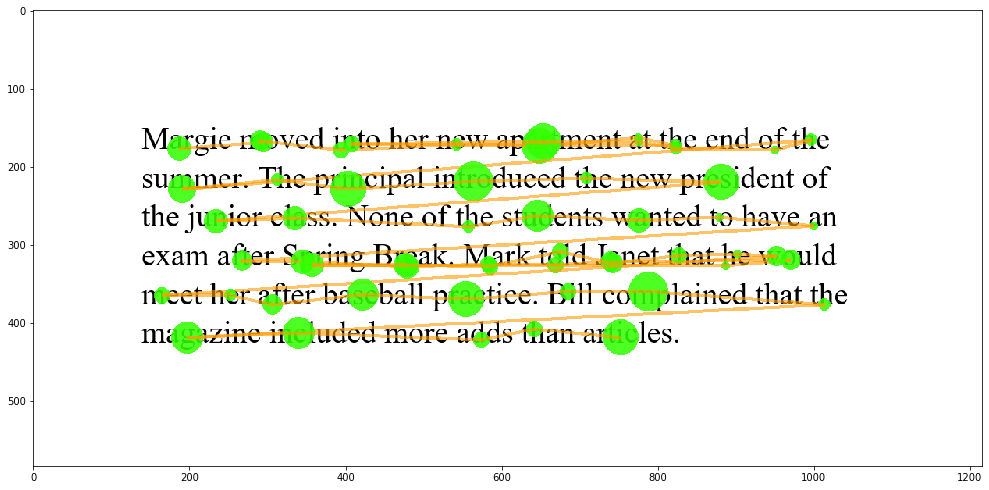

In [4]:
#error_test = correction.error_noise(5/10, 30, 5/10, data.copy())

correction.draw_fixation('synthetic_text.png', data['robot1'].copy())

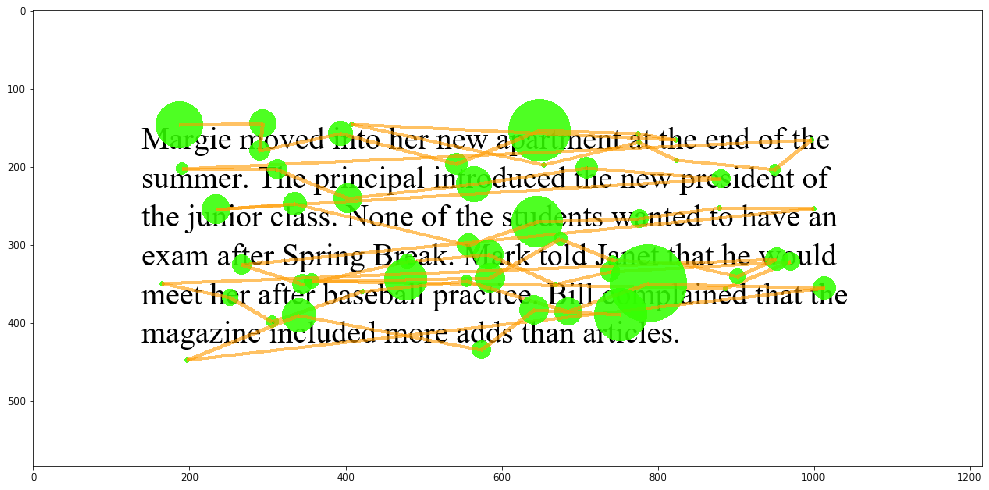

In [5]:
error_test = correction.error_noise(1, 30, 1, data['robot1'].copy())

#data = correction.generate_fixations_left(aois_with_tokens)
#error_test = correction.error_noise(5/10, 30, 5/10, data.copy())

correction.draw_fixation('synthetic_text.png', error_test)

1.0


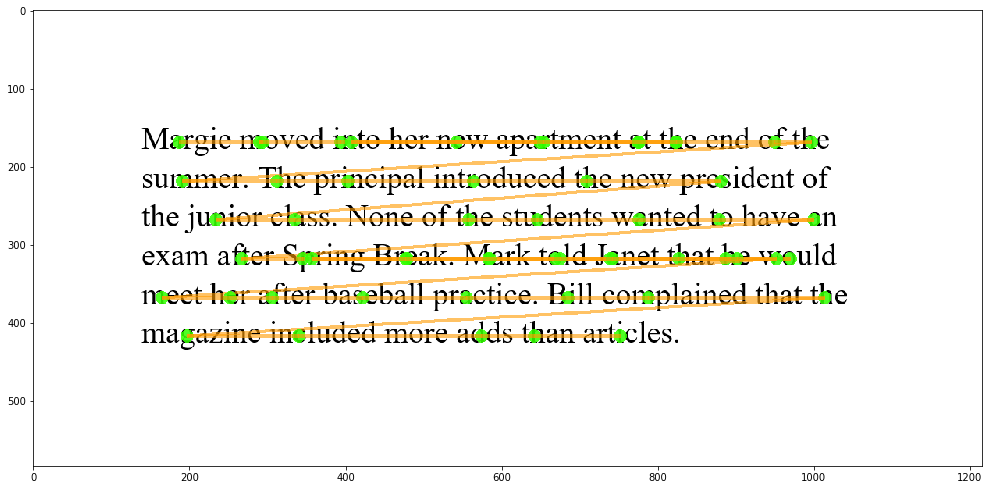

In [6]:
word_centers = correction.find_word_centers(aoi)
word_centers = np.array(word_centers.copy(), dtype=int)

# warp correction
np_array = np.array(error_test.copy(), dtype=int)
durations = np.delete(np_array, 0, 1)
durations = np.delete(durations, 0, 1)
np_array = np.delete(np_array, 2, 1)

warp_correction = algo.warp(np_array, word_centers)
percentage, match_list = correction.correction_quality(aoi, data['robot1'].copy(), warp_correction)
print(percentage)


correction.draw_correction('synthetic_text.png', warp_correction, match_list)

1.0


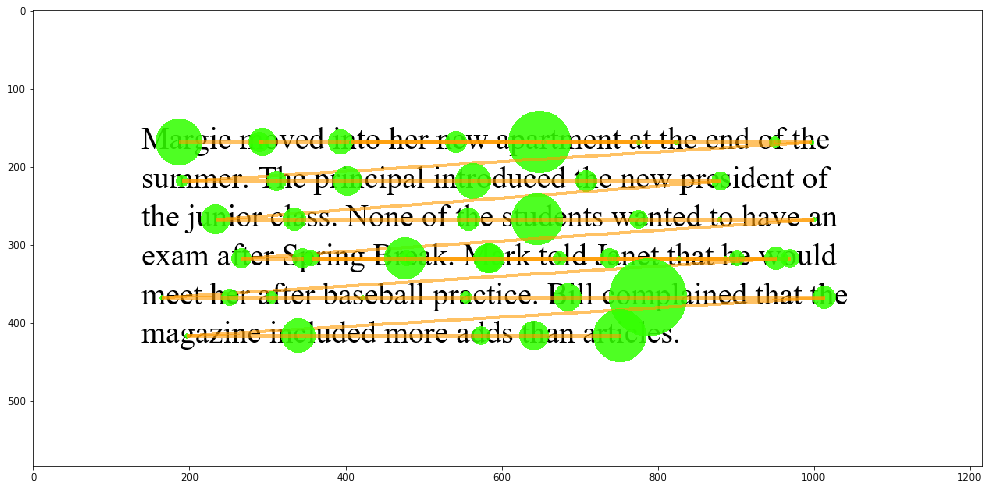

In [7]:
duration_word_centers = correction.find_word_centers_and_duration(aois_with_tokens)
duration_word_centers = np.array(duration_word_centers.copy(), dtype=int)


# warp+EZ correction
np_array = np.array(error_test.copy(), dtype=int)

warp_correction = algo.warp(np_array, duration_word_centers)
percentage, match_list = correction.correction_quality(aoi, data['robot1'].copy(), warp_correction)
print(percentage)


correction.draw_correction('synthetic_text.png', warp_correction, match_list)

Load classifier models

In [18]:
model_tl = tf.keras.models.load_model("saved_models_mix/model2")

Classification accuracy with incremental possibilities of errors

In [19]:
def predict(error_test, img_path, y_label):
    '''
    return 1 if the prediction is correct, 0 otherwise
    '''
    im = correction.fix_to_img(img_path, error_test)
    im_small = im.resize((input_y, input_x)) # shrink image to fit in model, shape defined in prev cell
    im_small_array = np.asarray(im_small)
    pred_percent = model_tl.predict(im_small_array.reshape(1, input_x, input_y, 3))
    pred = np.argmax(pred_percent, axis=1)
    # if pred != 0:
    #     print(f"correct: {y_label}, predicted: {pred}")
    if pred == y_label:
        return 1
    else:
        return 0

x = 584
y = 1216
input_x = x//2
input_y = y//2

In [12]:
noise_results = [[],[],[],[],[],[],[],[],[],[],[]]
shift_results = [[],[],[],[],[],[],[],[],[],[],[]]
droop_results = [[],[],[],[],[],[],[],[],[],[],[]]
offset_results = [[],[],[],[],[],[],[],[],[],[],[]]
no_error_results = [[],[],[],[],[],[],[],[],[],[],[]]

for robot_index in tqdm(range(30)):
    
    for error_probability in range(0, 11):
        synth_fixations = correction.generate_fixations_left(aois_with_tokens)
        
        # noise
        noise_test = correction.error_noise(error_probability/10.0, 30, error_probability/10, synth_fixations)
        if error_probability == 0:
            pred0 = predict(noise_test, image, 4)
        else:
            pred0 = predict(noise_test, image, 0)
        noise_results[error_probability].append(pred0)

        # shift
        line_ys = correction.find_lines_Y(aois_with_tokens)
        shift_test = correction.error_shift(error_probability/10.0, line_ys, synth_fixations) 
        if error_probability == 0:
            pred1 = predict(shift_test, image, 4)
        else:
            pred1 = predict(shift_test, image, 1)
        shift_results[error_probability].append(pred1)
        
        # droop
        droop_test = correction.error_droop(error_probability/10.0*5, synth_fixations)
        if error_probability == 0:
            pred2 = predict(droop_test, image, 4)
        else:
            pred2 = predict(droop_test, image, 2)
        droop_results[error_probability].append(pred2)

        # offset
        offset_test = correction.error_offset(error_probability/10.0*5, error_probability/10.0*5, synth_fixations)
        if error_probability == 0:
            pred3 = predict(offset_test, image, 4)
        else:
            pred3 = predict(offset_test, image, 3)
        offset_results[error_probability].append(pred3)

        # no error
        # no_error_test = synth_fixations
        # pred4 = predict(no_error_test, image, 4)
        # no_error_results[error_probability].append(pred4)

100%|██████████| 10/10 [01:25<00:00,  8.56s/it]


# Noise Error:

In [13]:
import statistics

def mean_error_group(results):
    new_list = []
    
    for result in results:
        new_list.append(statistics.mean(result))
        
    return new_list

In [14]:
mean_noise_results = mean_error_group(noise_results)
mean_shift_results = mean_error_group(shift_results)
mean_droop_results = mean_error_group(droop_results)
mean_offset_results = mean_error_group(offset_results)
# mean_no_error_results = mean_error_group(no_error_results)

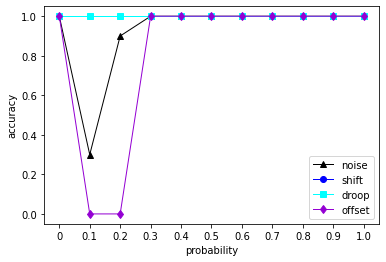

In [15]:
plt.plot(mean_noise_results, color='Black', linewidth=1, marker='^')
plt.plot(mean_shift_results, color='Blue', linewidth=1, marker='o')
plt.plot(mean_droop_results, color='Aqua', linewidth=1, marker='s')
plt.plot(mean_offset_results, color='DarkViolet', linewidth=1, marker='d')
# plt.plot(mean_no_error_results, color='red', linewidth=1, marker='^')

plt.legend(['noise', 'shift', 'droop', 'offset', "no error"])
plt.ylabel('accuracy')
plt.xlabel('probability')

x_ticks_labels = ['0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0']
plt.xticks(range(0, 11), x_ticks_labels)
plt.show()

In [26]:
print(mean_noise_results, mean_droop_results, mean_shift_results, mean_offset_results)

[1, 0.94, 1, 1, 1, 1, 1, 1, 1, 1, 1] [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [27]:
print("mean noise:", statistics.mean(mean_noise_results))
print("mean droop:", statistics.mean(mean_droop_results))
print("mean shift:", statistics.mean(mean_shift_results))
# print("mean no error:", statistics.mean(mean_no_error_results))

mean noise: 0.9945454545454545
mean droop: 1
mean shift: 1


In [13]:
print("mean attach:", statistics.mean(mean_attach_results))
print("mean chain:", statistics.mean(mean_chain_results))
print("mean regress:", statistics.mean(mean_regress_results))
print("mean warp:", statistics.mean(mean_warp_results))

mean attach: 0.911470731892273
mean chain: 0.9620081187233928
mean regress: 0.8825135111414607
mean warp: 0.9090651571502321
mean warp+EZ: 0.9256354539600808
mean warp+REG: 0.853936405976377
mean warp+EZ+REG: 0.8738391255687176
